In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Explore Data

      Unnamed: 0       patient  \
0              4  TCGA-3C-AALK   
1              7  TCGA-5T-A9QA   
2              8  TCGA-A1-A0SB   
3              9  TCGA-A1-A0SD   
4             10  TCGA-A1-A0SE   
...          ...           ...   
1094        1089  TCGA-S3-AA17   
1095        1091  TCGA-UU-A93S   
1096        1093  TCGA-WT-AB41   
1097        1095  TCGA-XX-A899   
1098        1097  TCGA-Z7-A8R5   

                                                  slide  age_at_diagnosis  \
0     TCGA-3C-AALK-01Z-00-DX1.4E6EB156-BB19-410F-878...                52   
1     TCGA-5T-A9QA-01Z-00-DX1.B4212117-E0A7-4EF2-B32...                52   
2     TCGA-A1-A0SB-01Z-00-DX1.B34C267B-CAAA-4AB6-AD5...                70   
3     TCGA-A1-A0SD-01Z-00-DX1.DB17BFA9-D951-42A8-91D...                59   
4     TCGA-A1-A0SE-01Z-00-DX1.04B09232-C6C4-46EF-AA2...                56   
...                                                 ...               ...   
1094  TCGA-S3-AA17-01Z-00-DX1.9B7DC02E-ECB2-4403-A89

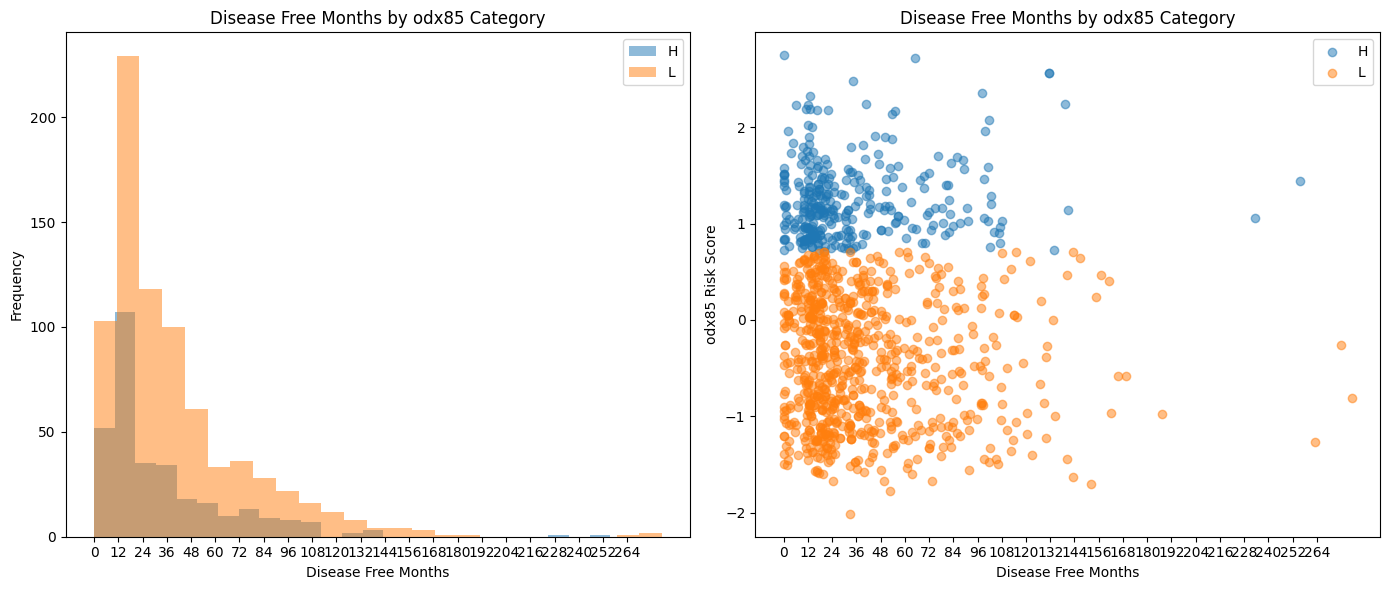

In [15]:
from src.data.data_loading import SLIDES_PRS_DATA
import matplotlib.pyplot as plt
import numpy as np

df = SLIDES_PRS_DATA.copy()
print(df)

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))  # You might want to adjust the figure size

# First subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.hist(df[df['odx85'] == 'H']['Disease_Free_Months'], alpha=0.5, label='H', bins=25)
plt.hist(df[df['odx85'] == 'L']['Disease_Free_Months'], alpha=0.5, label='L', bins=25)
plt.title("Disease Free Months by odx85 Category")
plt.xlabel("Disease Free Months")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.xticks(np.arange(0, 276, 12))

# Second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
dfH = df[df['odx85'] == 'H']
dfL = df[df['odx85'] == 'L']
plt.scatter(data=dfH, x='Disease_Free_Months', y="odx_train", alpha=0.5, label='H')
plt.scatter(data=dfL, x='Disease_Free_Months', y="odx_train", alpha=0.5, label='L')
plt.title("Disease Free Months by odx85 Category")
plt.xlabel("Disease Free Months")
plt.ylabel("odx85 Risk Score")
plt.legend(loc='upper right')
plt.xticks(np.arange(0, 276, 12))

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Set up S3 Bucket

## Preparing dataset metadata file

In [18]:
# import json
# import os
# import pandas as pd
# import numpy as np
# from src.utils import collect_patients_svs_files

# RESOURCE_DIR = '/data/resources'
# SVS_FILES = np.load(os.path.join(RESOURCE_DIR, "svs_files.npy"))
# PATIENT_FILES = [os.path.join(RESOURCE_DIR, "n0samples.csv"), os.path.join(RESOURCE_DIR, "n1samples.csv")]
# SLIDES_PRS = {k: v for f in PATIENT_FILES for k, v in collect_patients_svs_files(f, SVS_FILES).items()}
# SLIDES_PRS_DATA = pd.concat([pd.read_csv(f) for f in PATIENT_FILES], ignore_index=True)


# # slide_paths_filename = "riskformer_slides.json"

# # with open(os.path.join(RESOURCE_DIR, slide_paths_filename), 'w') as f:
# #     json.dump(SLIDES_PRS, f, indent=4)

## Upload train and test files to S3 bucket

In [4]:
!python -m src.data.data_loading --debug

2025-02-06 07:50:49,123 - src.utils - INFO - Setting seed to 42
2025-02-06 07:50:49,134 - __main__ - DEBUG - Created boto3 session
2025-02-06 07:50:49,137 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2025-02-06 07:50:49,195 - __main__ - DEBUG - Created S3 client
2025-02-06 07:50:49,236 - __main__ - DEBUG - Available buckets: [{'Name': 'tcga-riskformer-data-2025', 'CreationDate': datetime.datetime(2025, 2, 4, 23, 53, 47, tzinfo=tzlocal())}]
2025-02-06 07:50:49,251 - __main__ - INFO - Loaded 1099 SVS files.
2025-02-06 07:50:49,252 - __main__ - DEBUG - Dataset contains 1099 samples, 316 positive and 783 negative samples.
2025-02-06 07:50:49,253 - __main__ - DEBUG - Created Test Dataset with 218 samples, 109 positive and 109 negative samples.
2025-02-06 07:50:49,253 - __main__ - DEBUG - Created Train Dataset with 881 samples, 207 positive and 674 negative samples.
2025-02-06 07:50:49,253 - __main__ - INFO - Split data into 881 training sa

'/data/resources/TCGA-BRCA-2/8d64eaaf-515e-437c-818e-b0b7cb37366c/TCGA-GM-A2DM-01Z-00-DX1.652038F4-C370-40EB-A545-51062783C74C.svs'

In [22]:
test_file = list(SLIDES_PRS.keys())[0]
file_size = os.path.getsize(test_file) / (1024 * 1024)  # Convert bytes to MB
print(f"File size: {file_size:.2f} MB")

File size: 1152.49 MB


# Pre-process svs slides

In [4]:
from src.data.data_preprocess import *
import multiprocessing

test_files = [f.replace("./resources", "/data/resources") for f in SLIDES_PRS]
multiprocessing.set_start_method("fork", force=True)
all_coords, all_heatmaps = get_all_samplepoints(test_files, TILING_PARAMS[256], return_heatmap=True, parallel=True)


2025-02-04 06:31:17,636 - src.preprocess_slides - INFO - Processing 1099 slides using 4 workers.


/opt/tensorflow/lib/python3.10/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 1099/1099 [00:00<00:00, 3450254.56it/s]
2025-02-04 06:36:16,931 - src.preprocess_slides - INFO - Finished processing all slides in 299.29s


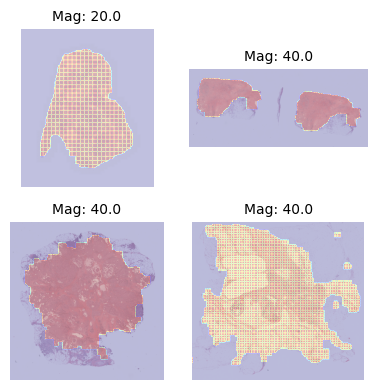

In [7]:
import matplotlib.pyplot as plt
import random
from src.data.data_loading import get_svs_thumb, open_svs

random.seed(1)
N = 4
sampled_files = random.choices(test_files, k=N)
sampled_arrays = [all_heatmaps[f] for f in sampled_files]
sampled_thumbs = [get_svs_thumb(f, size=DEFAULT_FOREGROUND_SIZE) for f in sampled_files]
sampled_mags = [open_svs(f)[1]['mag'] for f in sampled_files]

r = c = int(N**0.5)
fig, axs = plt.subplots(r, c, figsize=(4, 4))

for i in range(r):
    for j in range(c):
        axs[i, j].imshow(sampled_thumbs[i*r + j], alpha=0.5)
        axs[i, j].imshow(sampled_arrays[i*r + j], cmap='jet', vmax=1.0, alpha=0.25)
        axs[i, j].set_title(f"Mag: {sampled_mags[i*r + j]}", fontsize=10)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
save_file = 'n0n1_sample_coords.npz'
save_file = os.path.join(os.path.dirname(PATIENT_FILES[0]), save_file)

'/data/resources/n0n1_sample_coords.npz'

In [12]:
from src.utils import save_coords_dict

save_file = 'n0n1_sample_coords.npz'
save_file = os.path.join(os.path.dirname(PATIENT_FILES[0]), save_file)
save_coords_dict(all_coords, save_file)

# Set Up Model And Collect Features

In [1]:
import torch
from src.utils import set_seed
set_seed(42)

model_path = ""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# TODO
# Load UNI model

device(type='cuda')

## Process Coordinates

In [13]:
import os
from os.path import join, splitext, basename
import pickle
from time import time
from src.data.data_preprocess import SLIDES_PRS_DATA, SLIDES_PRS, PATIENT_FILES
from src.utils import load_coords_dict

data_dir = join("/data/resources", "riskformer_data")
os.makedirs(data_dir, exist_ok=True)

patient_df = SLIDES_PRS_DATA
patient_slide_paths = [f.replace("./resources", "/data/resources") for f in SLIDES_PRS]
patient_ids = patient_df.patient.unique()
patient_slides = [splitext(basename(f))[0] for f in patient_slide_paths]

coords_file = 'n0n1_sample_coords.npz'
coords_file = os.path.join(os.path.dirname(PATIENT_FILES[0]), coords_file)
coords = load_coords_dict(coords_file)

In [ ]:
# TODO
# import multiprocessing as mp
# from os.path import splitext, basename
# PS = 256

# save_dir = join(RESOURCE_DIR, "PRS_data_256_xl")
# os.makedirs(save_dir, exist_ok=True)
# os.makedirs(join(save_dir, "raw"), exist_ok=True)

# patient_ids = patient_df.patient.unique()
# patient_slides = [splitext(basename(f))[0] for f in patient_slide_paths]

# last_printed = [0]  # Using a list so that it can be modified inside the function
# def process_patient(patient):    
#     slides = list(patient_df.loc[patient_df.patient == patient].slide)
    
#     patient_features = []
#     patient_sequence_ids = []
#     patient_files = []
#     sequence_id = 0

#     for slide in slides:
#         slide_idx = patient_slides.index(slide)
#         mask, coords, fg_scale, crop_size = results[slide_idx]
#         test_file = patient_slide_paths[slide_idx]

#         mag = get_svs_mag(test_file)
#         features_mask = create_mask(coords, crop_size, filter_regions=False)
        
#         st = time()
#         # features = np.random.random((len(coords), 3))
    
#         df = process_coordinates(coords, test_file, mag, PS, crop_size)
#         features = extract_features_simclr(df, test_file, model_wrapper, PS, bs=768, prefetch=None, collect_projections=False, normalize=True)

#         # features = extract_features(test_file, coords, model256, PS, crop_size, bs=224)
#         # print(f"Executed in {(time() - st)/60:.2f}m")
        
#         padded_features = pad_and_split_features(features_mask, features)
#         # print([p.shape for p in padded_features])
#         for split in padded_features:
#             if min(split.shape[:2]) >= 15 and max(split.shape[:2]) >= 21:
#                 patient_features.append(split)
#                 patient_files.append(test_file)
#                 patient_sequence_ids.extend([sequence_id] * patient_features[-1].shape[0])
#                 sequence_id += 1
                
#     if len(patient_features) < 1:
#         print(patient)
#         assert len(patient_sequence_ids) == len(patient_files) == 0
    
#     patient_label = patient_df.loc[patient_df.patient == patient].odx85.values[0]
#     filename = join(save_dir, "raw", patient + ".npz")
    
#     feats_updated = [f for f in patient_features if np.any(np.array(f.shape[:2]) >= 3)]
#     patient_files_updated = [pf for f, pf in zip(feats_updated, patient_files) if np.any(np.array(f.shape[:2]) >= 3)]
#     if len(feats_updated) > 0:
#         data_dict = {}
#         for idx, feature in enumerate(feats_updated):
#             data_dict[f'feature_{idx}'] = feature
#         data_dict['label'] = patient_label
#         data_dict['patient_files'] = patient_files_updated
#         np.savez_compressed(filename, **data_dict)
    
#     return patient_features, patient_sequence_ids, patient_files

# results_parallel = []
# total_patients = len(patient_ids)
# last_printed_progress = 0

# for i, patient in enumerate(patient_ids, 1):
#     result = process_patient(patient)
#     results_parallel.append(result)
    
#     current_progress = (i / total_patients) * 100
#     if current_progress - last_printed_progress >= 10:  # Check if progress has increased by at least 10%
#         print(f"Processed: {i}/{total_patients} ({current_progress:.2f}%) patients")
#         last_printed_progress = current_progress

# # # Unpack results after processing
# # all_features, all_ids, all_patients = zip(*results_parallel)

2024-04-21 08:41:08,313 Subsampling and feature extraction started.
2024-04-21 08:41:08.317742: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-04-21 08:41:08.318036: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-04-21 08:41:08,491 Processed 0 batches out of 23...


# Background Tile

In [8]:
patient_df = SLIDES_PRS_DATA
patient_slide_paths = SLIDES_PRS

patient_ids = patient_df.patient.unique()
patient_slides = [splitext(basename(f))[0] for f in patient_slide_paths]

PS = 256

hipt = False
data_dir = join(RESOURCE_DIR, "PRS_data_256_sm")
data_dir += "_hipt" if hipt else ""
print(data_dir)

/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm


In [9]:
test_slide = SLIDES_PRS[10]
print(test_slide)
test_obj = OpenSlide(test_slide)
slide_mag = get_svs_mag(test_slide)
print(slide_mag)

in_s = 256 if slide_mag < 40 else 512
in_s, PS

./resources/TCGA-BRCA-2/6e1b44e9-94cc-455d-b5ec-b04d81f039c8/TCGA-A8-A06N-01Z-00-DX1.E25E65F8-DFE0-47CF-9FAB-B82EE8E321F7.svs
20.0


(256, 256)

/tmp/ipykernel_952998/1524719797.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  if im.min() < 255 and stats.mode(im, axis=None)[0][0]==255:


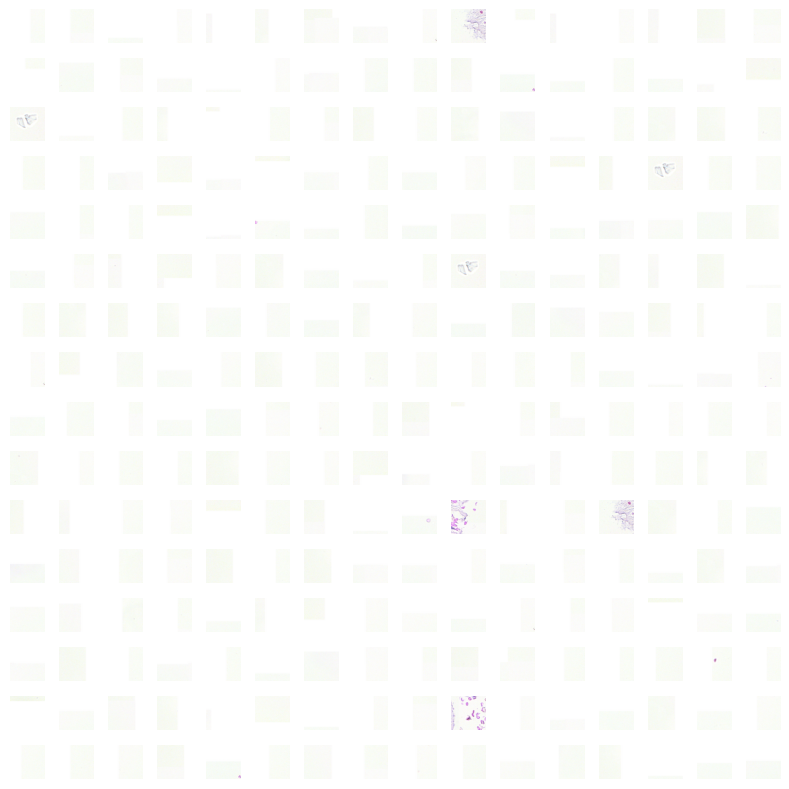

In [10]:
from scipy import stats

n = 16
max_tile = 32 * 5

coords = []
while len(coords) < n**2:
    x, y = np.random.choice(max_tile) * in_s, np.random.choice(max_tile) * in_s
    im = np.array(test_obj.read_region((x, y), 0, (in_s, in_s)).convert('RGB'))
    if im.min() < 255 and stats.mode(im, axis=None)[0][0]==255:
        if im.mean() > 240:
            coords.append((x, y))

s = 0.5
f, axs = plt.subplots(n, n, figsize=(s*n, s*n))
axs = axs.flatten()

for i, ax in enumerate(axs):
    x, y = coords[i]
    im = np.array(test_obj.read_region((x, y), 0, (in_s, in_s)).convert('RGB'))

    ax.imshow(im)
    ax.axis("off")
plt.tight_layout()

In [11]:
PROJ = True # Collect projections (True) or hiddens (False)

df = process_coordinates(coords, test_slide, slide_mag, PS, in_s)
background_feats = extract_features_simclr(df, test_slide, model_wrapper, PS, bs=32, prefetch=None, collect_projections=PROJ)

# background_feats = extract_features(test_slide, coords, model256, PS, in_s, bs=32)

2024-04-05 15:18:29,175 Subsampling and feature extraction started.
2024-04-05 15:18:29.179093: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-04-05 15:18:29.179376: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-04-05 15:18:29,308 Processed 0 batches out of 8...
2024-04-05 15:18:30,194 Processed 1 batches out of 8...
2024-04-05 15:18:30,299 Processed 2 batches out of 8...
2024-04-05 15:18:30,403 Processed 3 batches out of 8...
2024-04-05 15:18:30,468 Pr

In [12]:
data_dir

'/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_sm'

In [13]:
feats_mean = np.load(join(data_dir, "features_avg.npy"))
feats_std = np.load(join(data_dir, "features_std.npy"))

In [14]:
import tensorflow as tf

background_tile = background_feats.mean(axis=0)
background_tile_norm = (background_tile - feats_mean) / feats_std
background_tile_file = join(data_dir, "background_tile.npy")

np.save(background_tile_file, background_tile)
np.save(background_tile_file.replace(".npy", "_norm.npy"), background_tile_norm)

# Visualizing Feature Shapes

In [60]:
from glob import glob
from os.path import join
from multiprocessing import Pool, cpu_count
from time import time

raw_dir = join(data_dir, "raw")
raw_files = glob(join(raw_dir, "*.npz"))

In [ ]:
def count_feats(file_path):
    data = np.load(file_path, allow_pickle=True)
    return len([key for key in data if "feature" in key])

with Pool(cpu_count()) as pool:
    counts = pool.map(count_feats, raw_files)

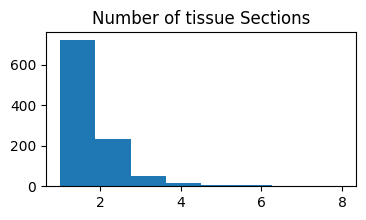

In [153]:
SIZE = 2
plt.figure(figsize=(SIZE * 2, SIZE))

plt.hist(counts, bins=max(counts))

plt.title("Number of tissue Sections", fontsize=12)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.savefig("Number Sections.png")

In [27]:
def count_feats(file_path):
    data = np.load(file_path, allow_pickle=True)
    return np.stack([data[key].shape for key in data if "feature" in key])

with Pool(cpu_count()) as pool:
    all_shapes = pool.map(count_feats, raw_files)

In [38]:
all_shapes = np.concatenate([s[:, :2] for s in all_shapes])
all_shapes

array([[127, 119],
       [ 56,  42],
       [ 55,  41],
       ...,
       [ 32,  25],
       [ 64,  93],
       [ 46,  34]])

2024-01-11 08:31:10,957 No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


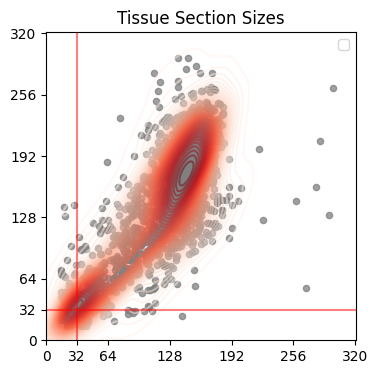

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

SIZE = 4
plt.figure(figsize=(SIZE, SIZE))

# KDE plot
sns.kdeplot(x=all_shapes[:, 0], y=all_shapes[:, 1], cmap="Reds", fill=False, thresh=0, levels=50, alpha=0.5)

# Plot scatter of your data
plt.scatter(all_shapes[:, 0], all_shapes[:, 1], 20, alpha=0.75, color='gray')

max_feat_size = 321
tile_size = 32

plt.hlines(tile_size, 0, max_feat_size, color="r", alpha=0.5)
plt.vlines(tile_size, 0, max_feat_size, color="r", alpha=0.5)
plt.ylim([0, max_feat_size])
plt.xlim([0, max_feat_size])

# Add ticks for the x and y axis
x_ticks = np.arange(0, max_feat_size, 64).tolist() + [tile_size]
y_ticks = np.arange(0, max_feat_size, 64).tolist() + [tile_size]

plt.xticks(sorted(x_ticks), fontsize=10)
plt.yticks(sorted(y_ticks), fontsize=10)

plt.title("Tissue Section Sizes", fontsize=12)
plt.legend()
plt.savefig("Section Sizes.png")

# Save features

In [42]:
import shutil
new_dir = save_dir
old_dir = new_dir.replace("_hipt", "")
print(save_dir)
print(old_dir)

if not exists(join(new_dir, "train")):
    os.mkdir(join(new_dir, "train"))
    os.mkdir(join(new_dir, "test"))

for i, patient in enumerate(patients):
    patient_label = SLIDES_PRS_DATA.loc[SLIDES_PRS_DATA.patient == patient].odx85.values[0]
    filename = join(save_dir, patient + ".npz")
    
    if os.path.exists(join(old_dir, "train")):
        if os.path.exists(join(old_dir, "train", patient + ".npz")):
            filename = join(new_dir, "train", patient + ".npz")
        else:
            filename = join(new_dir, "test", patient + ".npz")
    
    
    old_filename = join(new_dir, patient + ".npz")
    
    
    # Move the file from old_filename to filename
    if os.path.exists(old_filename):
        shutil.move(old_filename, filename)

/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256_hipt
/home/ubuntu/notebooks/cpc_hist/resources/PRS_data_256


In [19]:
save_dir = join(RESOURCE_DIR, "PRS_data_256")

for feats, patient_files in zip(all_features, all_patients):
    
    patient = SLIDES_PRS_DATA.loc[SLIDES_PRS_DATA.slide == splitext(basename(patient_files[0]))[0]].patient.values[0]
    label = SLIDES_PRS_DATA.loc[SLIDES_PRS_DATA.patient == patient].odx85.values[0]
    
    filename = join(save_dir, patient + ".npz")
    
    # Filter features based on shape criteria
    feats_updated = [f for f in feats if np.any(np.array(f.shape[:2]) >= 3)]
    
    # Update patient_files to correspond to feats_updated
    patient_files_updated = [pf for f, pf in zip(feats, patient_files) if np.any(np.array(f.shape[:2]) >= 3)]
    
    if len(feats_updated) > 0:
        # Save each feature individually
        data_dict = {}
        for idx, feature in enumerate(feats_updated):
            data_dict[f'feature_{idx}'] = feature
        
        data_dict['label'] = label
        data_dict['patient_files'] = patient_files_updated

        np.savez_compressed(filename, **data_dict)

In [20]:
import os
from os.path import join, exists
from shutil import move
import random

# Collect filepaths
filepaths = [join(save_dir, f) for f in os.listdir(save_dir) if f.endswith('.npz')]

# Randomly shuffle the filepaths
random.shuffle(filepaths)

# Split the filepaths into test and train
test_size = int(0.25 * len(filepaths))
test_filepaths = filepaths[:test_size]
train_filepaths = filepaths[test_size:]

# Create test and train directories if they don't exist
test_dir = join(data_dir, "test")
train_dir = join(data_dir, "train")

if not exists(test_dir):
    os.makedirs(test_dir)

if not exists(train_dir):
    os.makedirs(train_dir)

# Move files to their respective directories
for filepath in test_filepaths:
    move(filepath, join(test_dir, os.path.basename(filepath)))

for filepath in train_filepaths:
    move(filepath, join(train_dir, os.path.basename(filepath)))

# Vis Heatmaps

In [59]:
rawdir

NameError: name 'rawdir' is not defined

In [111]:

current_ids

['TCGA-GM-A2DM',
 'TCGA-E9-A3QA',
 'TCGA-E2-A10F',
 'TCGA-C8-A1HN',
 'TCGA-AC-A7VC',
 'TCGA-EW-A1P3',
 'TCGA-AR-A1AW',
 'TCGA-AR-A24P',
 'TCGA-BH-A1EY',
 'TCGA-BH-A0HU',
 'TCGA-A8-A06N',
 'TCGA-BH-A18F',
 'TCGA-D8-A1JT',
 'TCGA-A8-A0A2',
 'TCGA-D8-A27M',
 'TCGA-BH-A0H6',
 'TCGA-A8-A07C',
 'TCGA-AC-A2QJ',
 'TCGA-E9-A1N8',
 'TCGA-XX-A89A',
 'TCGA-A2-A04T',
 'TCGA-OL-A5DA',
 'TCGA-AC-A62X',
 'TCGA-A2-A04R',
 'TCGA-EW-A1OW',
 'TCGA-B6-A0X7',
 'TCGA-AN-A0AM',
 'TCGA-GM-A2DK',
 'TCGA-AR-A1AT',
 'TCGA-A7-A13G',
 'TCGA-E9-A1R6',
 'TCGA-BH-A0WA',
 'TCGA-A8-A07Z',
 'TCGA-5T-A9QA',
 'TCGA-A2-A0CZ',
 'TCGA-BH-A0EB',
 'TCGA-C8-A1HF',
 'TCGA-AR-A2LN',
 'TCGA-A8-A08H',
 'TCGA-BH-A0B6',
 'TCGA-AN-A046',
 'TCGA-A7-A4SE',
 'TCGA-BH-A0H0',
 'TCGA-A8-A091',
 'TCGA-A7-A0DB',
 'TCGA-BH-A1EU',
 'TCGA-BH-A0RX',
 'TCGA-A8-A0A4',
 'TCGA-GM-A2DB',
 'TCGA-AO-A03V',
 'TCGA-E2-A15C',
 'TCGA-A7-A5ZV',
 'TCGA-A7-A4SD',
 'TCGA-A7-A0DA',
 'TCGA-C8-A1HE',
 'TCGA-S3-A6ZF',
 'TCGA-AN-A0FV',
 'TCGA-AN-A0AJ',
 'TCGA-A8-A08G

In [139]:
slides_to_use = SLIDES_PRS
all_patients = ["-".join(basename(s).split("-")[:3]) for s in slides_to_use]
current_ids = ["-".join(os.path.splitext(os.path.basename(s))[0].split("-")[:3]) for s in slides_to_use]

testpatient = "TCGA-A2-A0EM"
testpatient = "TCGA-GM-A2DM"
testpatient = all_patients[7]
testidx = current_ids.index(testpatient)

testfile = slides_to_use[testidx]
slideObj = OpenSlide(testfile)
slide_mag = float(slideObj.properties["aperio.AppMag"].replace(",", "."))
thumb = slideObj.get_thumbnail((800, 800))

testfile = join(raw_dir, testpatient + ".npz")
testexample = np.load(testfile, allow_pickle=True)
feature_idx = list(testexample["patient_files"]).index(slides_to_use[testidx])
testfeature = testexample[f"feature_{feature_idx}"]

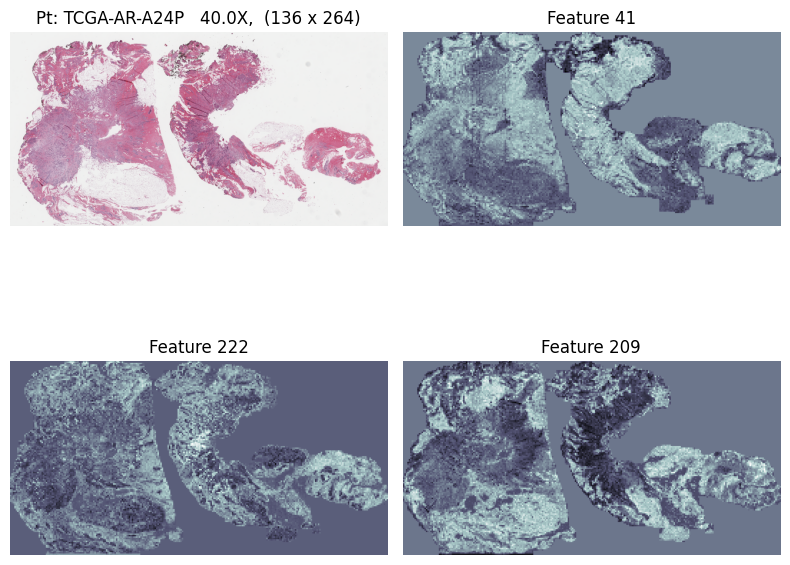

In [142]:
hw = float(testfeature.shape[0])/ testfeature.shape[1]
SIZE = 4

f, ax = plt.subplots(2, 2, figsize=(SIZE * 2, SIZE / hw))
ax = ax.flatten()

ax[0].imshow(thumb)
ax[0].set_title(f"Pt: {testpatient}   {slide_mag:.1f}X,  " + f"({testfeature.shape[0]} x {testfeature.shape[1]})")

for i, feat_num in zip(range(1, 4), [41, 222, 209]):
    feat_slice = testfeature[..., feat_num]
    slice_min, slice_max = feat_slice.min(), feat_slice.max()
    ax[i].imshow(feat_slice, cmap='bone_r')
    ax[i].set_title(f"Feature {feat_num}", fontsize=12)

for i in range(len(ax)):
    ax[i].axis("off")
plt.tight_layout()
plt.savefig("figures\example_features.png")

In [154]:
N = 4

testpatients = [all_patients[i] for i in range(N)]
testidxs = [current_ids.index(testpatient) for testpatient in testpatients]

testfiles = [slides_to_use[testidx] for testidx in testidxs]
thumb = [OpenSlide(testfile).get_thumbnail((800, 800)) for testfile in testfiles]
f, ax = plt.subplots(2, 2, figsize=(SIZE * 2, SIZE / hw))
ax = ax.flatten()

ax[0].imshow(thumb)
ax[0].set_title(f"Pt: {testpatient}   {slide_mag:.1f}X,  " + f"({testfeature.shape[0]} x {testfeature.shape[1]})")

for i, feat_num in zip(range(1, 4), [41, 222, 209]):
    feat_slice = testfeature[..., feat_num]
    slice_min, slice_max = feat_slice.min(), feat_slice.max()
    ax[i].imshow(feat_slice, cmap='bone_r')
    ax[i].set_title(f"Feature {feat_num}", fontsize=12)

for i in range(len(ax)):
    ax[i].axis("off")
plt.tight_layout()
plt.savefig("example_features.png")

[(11, 15, 3)]


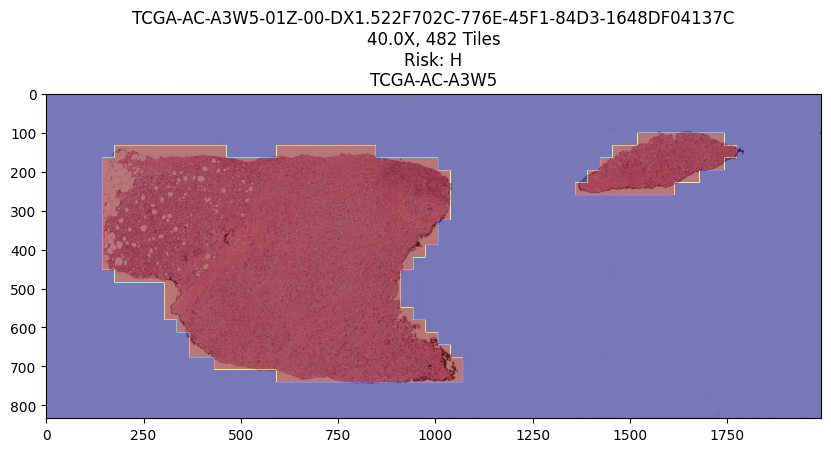

In [78]:
N = len(all_patients)
# N = 25
count = 0 
for i in range(N):
    splits = all_features[i]
    files = all_patients[i]
    patient = patients[i]
    
    shapes = [np.array(s.shape[:2]) for s in splits]
    if len(splits) > 1:
        continue
    
    if np.any([np.any(s < 12) for s in shapes]):
        print([s.shape for s in splits])
        for test_file in set(files):
            slide_idx = SLIDES_PRS.index(test_file)
            mask, coords, fg_scale, crop_size = results[slide_idx]
            heatmap = coords_to_heatmap(coords, fg_scale, crop_size, mask.shape)
            f, ax, cax = visualize_samples(OpenSlide(test_file), test_file, heatmap, fg_scale, len(coords), PS, SLIDES_PRS_DATA, alpha=0.5)
            ax.set_title(ax.get_title() + f"\n{patient}")
            count += 1
    # if count >= 10:
    #     break


In [ ]:
# Save arrays to disk
np.save(os.path.join(RESOURCE_DIR, "ViT", "SLIDES_PRS.npy"), SLIDES_PRS)
np.save(os.path.join(RESOURCE_DIR, "ViT", "all_features.npy"), all_features)
np.save(os.path.join(RESOURCE_DIR, "ViT", "all_ids.npy"), all_masks)

In [ ]:
\

# Fix Paddings

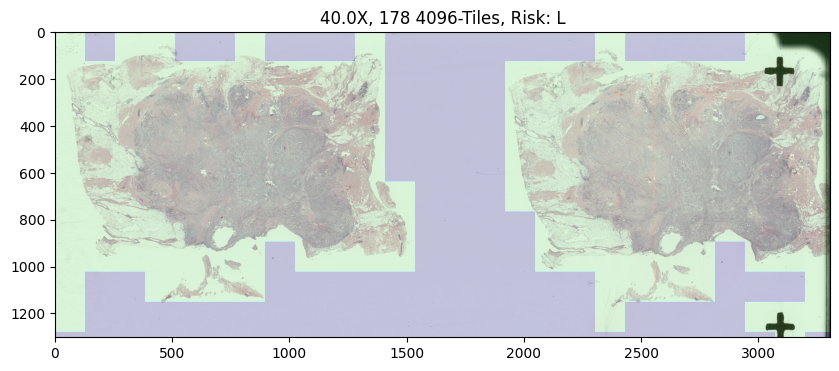

In [8]:
i = 5
test_file = SLIDES_PRS[i]

slideObj, heatmap, coords, fg_scale = eval_slide_samples(test_file, TILING_PARAMS[PS], RESOURCE_DIR, mag=MAG)
visualize_samples(slideObj, test_file, heatmap, fg_scale, len(coords), PS, SLIDES_PRS_DATA, alpha=0.2)

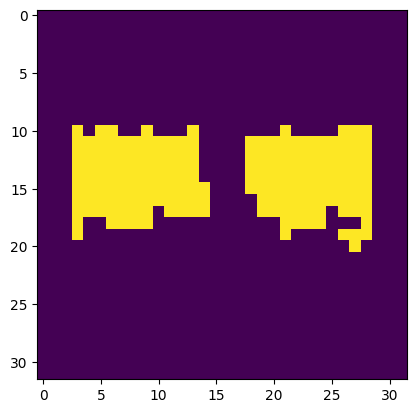

In [9]:
coords_mask = create_mask(coords, PS, slideObj, MAG)
plt.imshow(coords_mask)

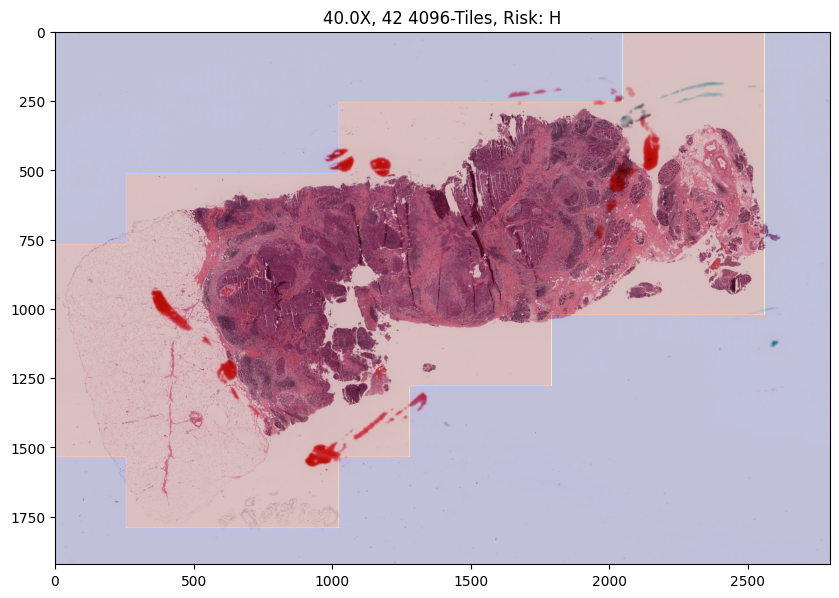

In [17]:
i = 1
test_file = SLIDES_PRS[i]

slideObj, heatmap, coords, fg_scale = eval_slide_samples(test_file, TILING_PARAMS[PS], RESOURCE_DIR, mag=MAG)
visualize_samples(slideObj, test_file, heatmap, fg_scale, len(coords), PS, SLIDES_PRS_DATA, alpha=0.2)

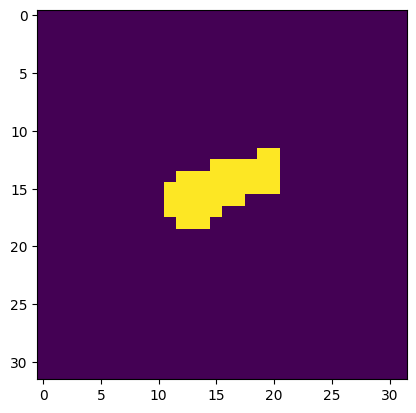

In [18]:
coords_mask = create_mask(coords, PS, slideObj, MAG)
plt.imshow(coords_mask)

In [29]:
def augment_np(x):
    # Calculate bounding box
    y_indices, x_indices = np.where(x)
    xmin, ymin = np.min(x_indices), np.min(y_indices)
    xmax, ymax = np.max(x_indices), np.max(y_indices)
    
    w = x.shape[1]
    # Calculate bounding box dimension and factor
    bbox_dim = max(xmax, ymax, w - ymin, w - xmin) - 2
    factor = float(bbox_dim) / float(x.shape[1])

    # Crop, Rotate and Flip
    x = random_crop_np(x, factor)
    x = random_rotate_np(x)
    x = random_flip_np(x)

    return x

def random_crop_np(x, factor):
    # Crop
    crop_size = np.random.randint(int(factor * x.shape[1]), x.shape[1])
    crop_start_x = np.random.randint(0, x.shape[1] - crop_size)
    crop_start_y = np.random.randint(0, x.shape[0] - crop_size)

    return x[crop_start_y:crop_start_y+crop_size, crop_start_x:crop_start_x+crop_size]

def random_rotate_np(x):
    # Rotate
    k = np.random.randint(0, 4)
    return np.rot90(x, k)

def random_flip_np(x):
    # Flip
    if np.random.rand() > 0.5:
        x = np.fliplr(x)
    if np.random.rand() > 0.5:
        x = np.flipud(x)

    return x

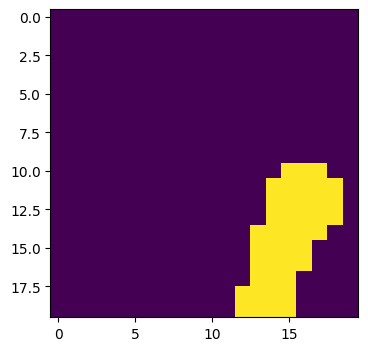

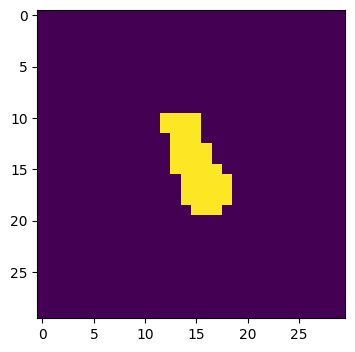

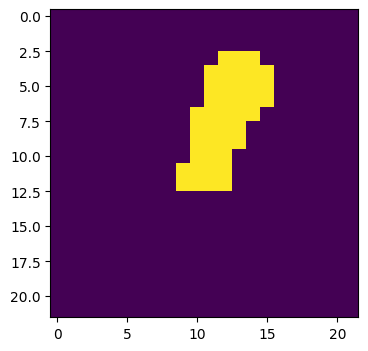

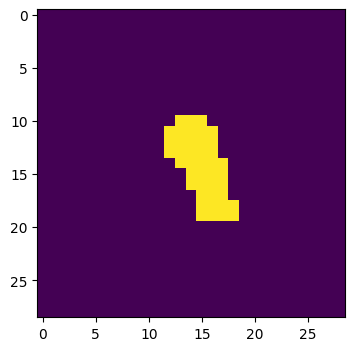

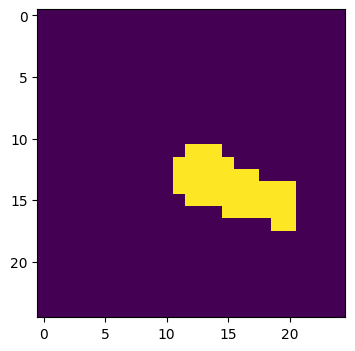

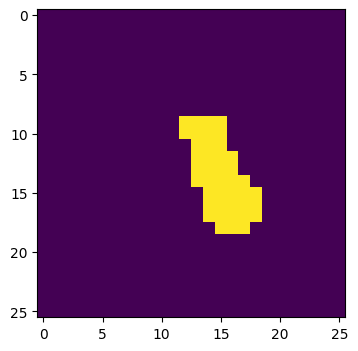

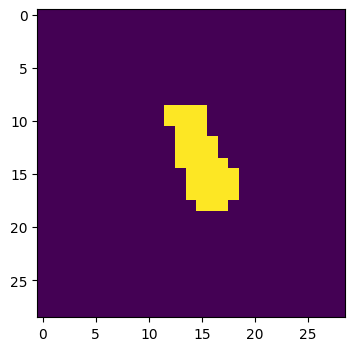

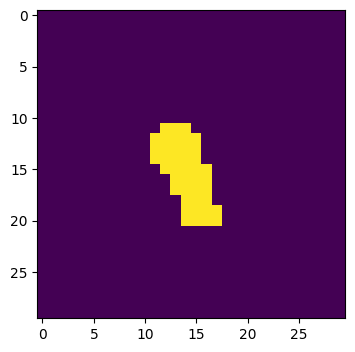

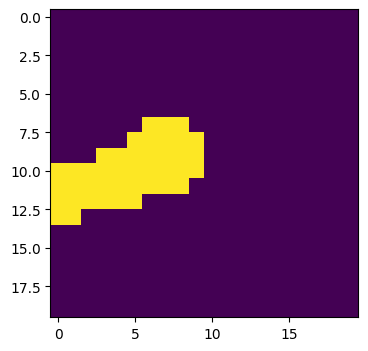

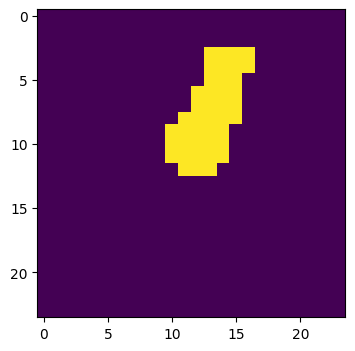

In [30]:
# Example usage
for i in range(10):
    coords_mask = create_mask(coords, PS, slideObj, MAG)
    coords_mask_crop = augment_np(coords_mask)
    f, ax = plt.subplots(1,1, figsize=(4, 4))
    ax.imshow(coords_mask_crop)